In [1]:
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime
import numpy as np
from io import StringIO
from csv import writer 

import xml.etree.ElementTree as ET
import csv

#import folium
#import bs4
#mport requests
#import ast

# Apply the default theme
sns.set_theme()

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
tree = ET.parse('2022-09-22.gpx') # create element tree object

In [3]:
root = tree.getroot() # get root element

In [4]:
date = root[1][0].text
date

'2022-09-22'

In [5]:
output = StringIO()
csv_writer = writer(output)
COLUMN_NAMES = ['time','latitude', 'longitude', 'elevation', 'heart_rate', ]

In [6]:
for elem in root[1][2]:
    ele = elem[0].text
    time = elem[1].text
    hr = elem[2][0][0].text
    lat = elem.get('lat')
    lon = elem.get('lon')
    row = [time, lat, lon, ele, hr]
    csv_writer.writerow(row)
    
output.seek(0) # we need to get back to the start of the BytesIO
df = pd.read_csv(output, header=None, names=COLUMN_NAMES)

In [7]:
# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
df['cumulative_miles'] = 0.000621371 * df['cumulative_distance']
df['time']= pd.to_datetime(df['time'])
df['cumulative_time'] = df['time']-df['time'].min()
df['cumulative_time'] =df['cumulative_time'] / np.timedelta64(1, 'm')

In [8]:
# get time elapsed for each row
df['time_diff'] = (df['time'] - df['time'].shift(+1)) / pd.Timedelta(seconds=1)
#df['time_diff'].max()

In [9]:
# Convert to mph
df['speed_mph'] = df['distance']/df['time_diff']  * 2.23694 # convert to mph
df['rolling_realspeed'] = df['speed_mph'].rolling(10).mean()

In [10]:
# get summary info
print("Activity Date:", date)
print("Min Elevation (ft):", "%.2f" % round(df['elevation'].min(), 2))
print("Max Elevation (ft):", "%.2f" % round(df['elevation'].max(), 2))
print("Total Time (min):", "%.2f" % round(df['cumulative_time'].max(), 2))
print("Stopped Time (min):", round(len(df[(df['distance'] < 0.5)]) / 60, 2))
print("Moving Time (min):", round(df['cumulative_time'].max() - (len(df[(df['distance'] < 0.5)]) / 60), 2))
print("Total Distance (miles):", "%.2f" % round(df['cumulative_miles'].max(), 2))
print("Max Speed (mph):", "%.2f" % round(df['rolling_realspeed'].max(), 2))
print("Avg Speed (mph):", "%.2f" % round(df['rolling_realspeed'].mean(), 2))
print("Max HR:", "%.2f" % round(df['heart_rate'].max(), 2))
print("Avg HR:", "%.2f" % round(df['heart_rate'].mean(), 2))

Activity Date: 2022-09-22
Min Elevation (ft): 19.90
Max Elevation (ft): 52.00
Total Time (min): 39.85
Stopped Time (min): 0.17
Moving Time (min): 39.68
Total Distance (miles): 11.26
Max Speed (mph): 33.11
Avg Speed (mph): 17.17
Max HR: 172.00
Avg HR: 145.42


<Figure size 960x480 with 0 Axes>

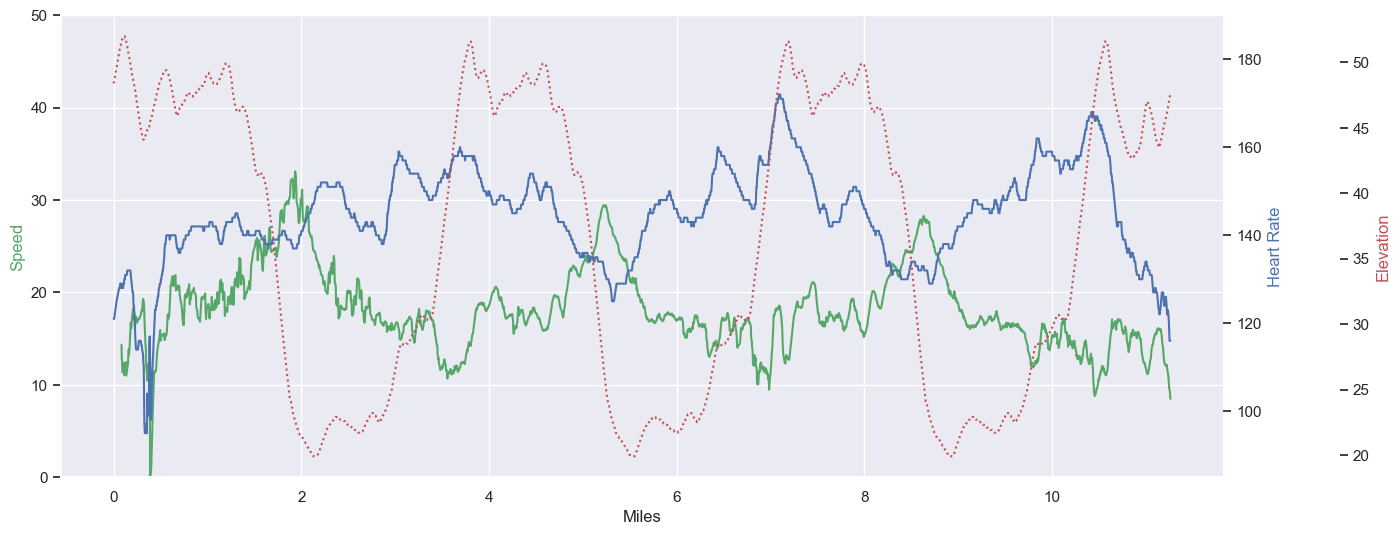

In [11]:
# graph speed

figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y1 = df.rolling_realspeed
y2 = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax3.plot(x, y3, 'r:')

ax1.set_xlabel('Miles')
ax1.set_ylabel('Speed', color='g')
ax2.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')

ax2.grid(False)
ax3.grid(False)

ax1.set_ylim(0,50)
ax2.set_ylim(df['heart_rate'].min()-10,190)

plt.show()

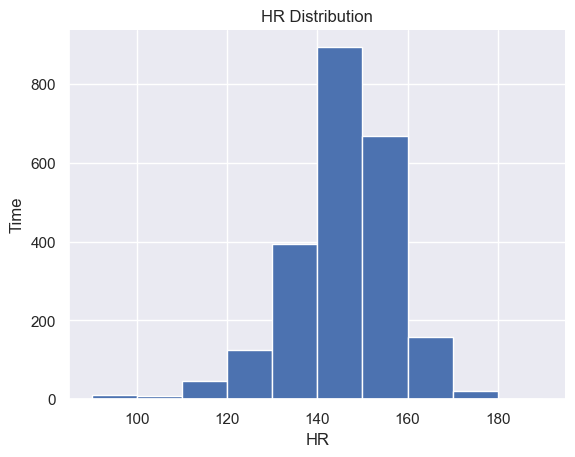

In [12]:
# the histogram of the data
n, bins, patches = plt.hist(df['heart_rate'], 10, range=(90,190))

plt.xlabel('HR')
plt.ylabel('Time')
plt.title('HR Distribution')
plt.show()

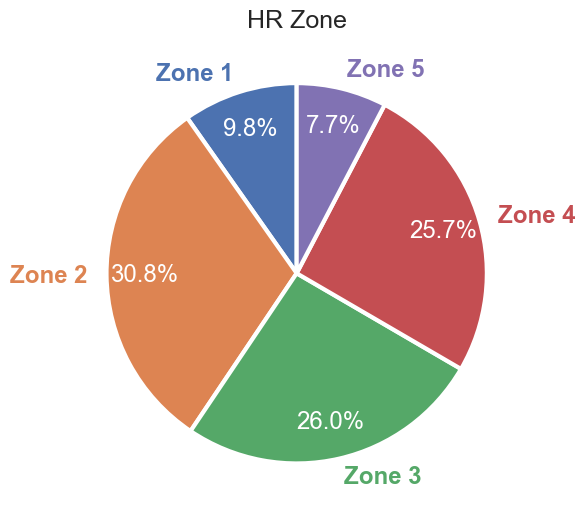

In [13]:
HR_zone_bins = [0, 131, 144, 151, 160, 200] # based off max hr
#HR_zone_bins = [0, 108, 129, 139, 159, 200] # based off LTHR
hr_count, division = np.histogram(df['heart_rate'], bins = HR_zone_bins)
hr_count = pd.DataFrame(hr_count)
x = hr_count[0]

labels = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(
    x, labels=labels, pctdistance=0.8, # controls distance from center of %
    autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('HR Zone', fontsize=18)

plt.tight_layout()

In [14]:
hrdf = pd.DataFrame([labels,x]).T
hrdf[2] = hrdf[1]/hrdf[1].sum()*100
hrdf = hrdf.rename({0: 'Zone', 1: 'Minutes',2: 'Percent', }, axis='columns')
hrdf['Minutes'] = hrdf['Minutes']/60
hrdf

,Zone,Minutes,Percent
0,Zone 1,3.783333,9.767642
1,Zone 2,11.933333,30.80895
2,Zone 3,10.083333,26.032702
3,Zone 4,9.966667,25.731497
4,Zone 5,2.966667,7.659208


<Figure size 960x480 with 0 Axes>

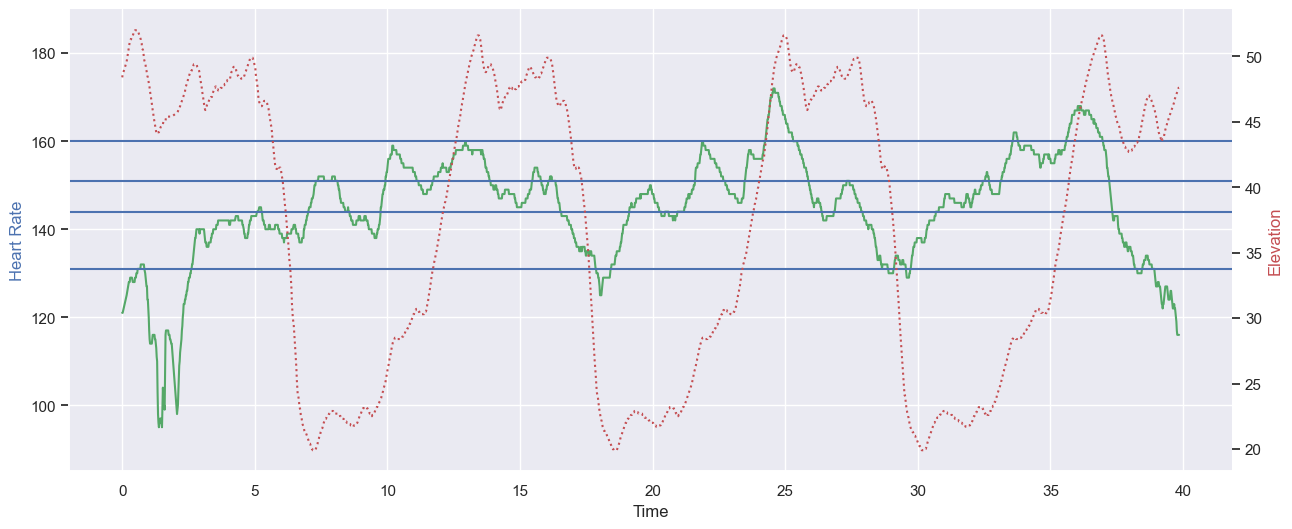

In [17]:
# Plot HR zones
figure(figsize=(12, 6), dpi=80)

x = df.cumulative_time
y = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax3 = ax1.twinx()
ax1.plot(x, y, 'g-')
ax3.plot(x, y3, 'r:')

ax1.set_xlabel('Time')
ax1.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')
ax1.set_ylim(df['heart_rate'].min()-10,190)

ax3.grid(False)

ax1.axhline(y=HR_zone_bins[1]) # plot zone lines
ax1.axhline(y=HR_zone_bins[2])
ax1.axhline(y=HR_zone_bins[3])
ax1.axhline(y=HR_zone_bins[4])

plt.show()